In [4]:
import vtk
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
from IPython.display import HTML
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import sys
from time import sleep

In [5]:
def vtp2df(file_name):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(file_name)
    reader.Update()
    pdata = reader.GetOutput()
    x, y, p, v_x, v_y, b = [], [], [], [], [], []
    for i in range(pdata.GetNumberOfPoints()):
        x.append(pdata.GetPoint(i)[0])
        y.append(pdata.GetPoint(i)[1])
        p.append(pdata.GetPointData().GetArray('Pressure').GetValue(i))
        v_x.append(pdata.GetPointData().GetArray('Velocity').GetTuple(i)[0])
        v_y.append(pdata.GetPointData().GetArray('Velocity').GetTuple(i)[1])
    return pd.DataFrame({
        "x": x, "y": y, "pressure": p, "velocity_x": v_x, "velocity_y": v_y
    })

In [6]:
# Declare parameters (time -> ms, space -> m)
# cpp file outputs at desired rate so values set as 1 
time_step = 1     
import_freq = 1 
total_file = 462

time_series = []
data = []

dx = 0.2

#domain dimensions
min_x = 0
max_x = 20
min_y = 0
max_y = 10

x = np.arange(min_x, max_x, dx)
y = np.arange(min_y, max_y, dx)

# Import file into list of panda dataframe
for i in range(int(total_file/import_freq)):
    time_series.append(i*time_step*import_freq)
    temp = vtp2df('./ACSE4_Group_Project3/example_%d.vtp' %time_series[i])
    data.append(temp[:])
 

In [7]:
# Extract information for each selected time step
water_heights = []
crest_xs = []
crest_ys = []
Wave_heights = []

# time for each iteration used
time_in_s = [i *(50*0.0013) for i in time_series]

# Generate and extract data from each time frame
for itr in range(len(data)):
    max_h = np.zeros((int(max_x/dx),1))  # clear max_h
    # obtain water surface
    for i in range(data[itr].shape[0]):
        if (data[itr].y[i]>min_y and data[itr].y[i]<max_y and data[itr].x[i]>min_x and data[itr].x[i]<max_x):
            current_y = data[itr].y[i]
            bin_x = int(data[itr].x[i]/dx)
            if max_h[bin_x] < current_y:
                max_h[bin_x] = current_y
                
    # smoothing the water surface
    max_h2 = np.convolve(max_h.flatten(), np.ones((2,))/2, mode='same')    
    water_heights.append(max_h2)
                
    # computing the crest location from water surface
    crest_x = np.argmax(max_h2[1:int(max_x/dx)]-1)*dx+dx
    crest_y = max(max_h2[1:int(max_x/dx)-1])
    crest_xs.append(crest_x)
    crest_ys.append(crest_y)
    
    #computing wave height
    height = max(max_h2[1:int(max_x/dx)-1]) - min(max_h2[1:int(max_x/dx)-1])
    Wave_heights.append(height)

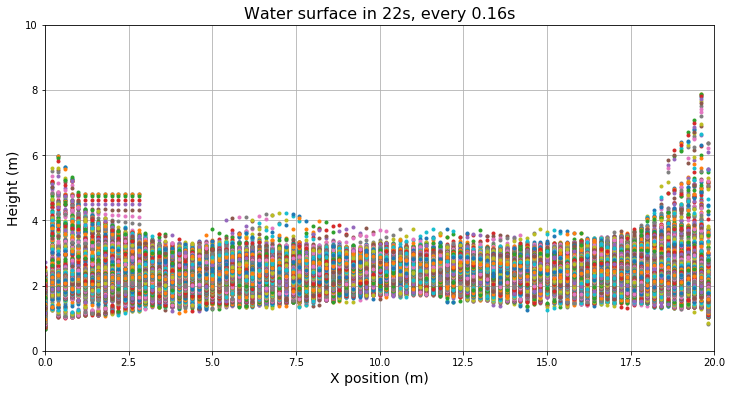

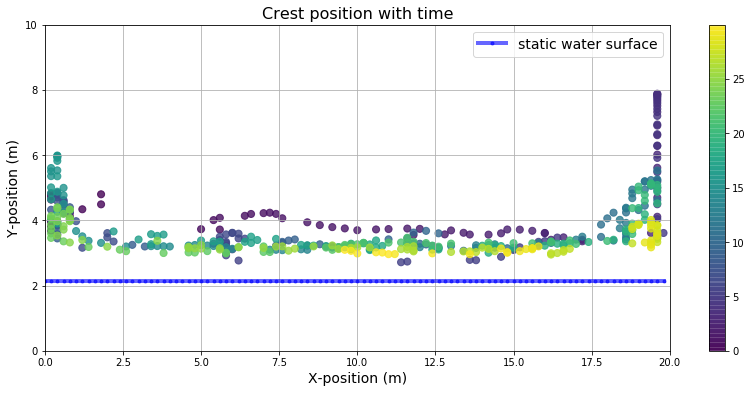

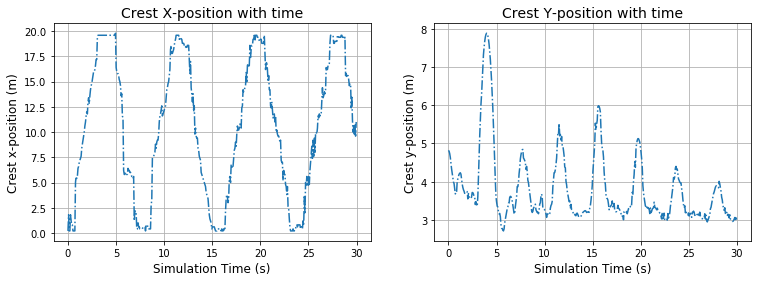

In [8]:
# -------- TASK 5 answer --------

# ploting changing crest_x, crest_y, and water_surface with time

fig = plt.figure(figsize=(12,6))
for itr in range(len(data)):
    plt.plot(x,water_heights[itr][:], '.')
    
plt.title('Water surface in 22s, every 0.16s', fontsize = 16)
plt.xlabel('X position (m)', fontsize = 14)
plt.ylabel('Height (m)', fontsize = 14)
plt.xlim([0,20])
plt.ylim([0,10])
plt.grid()


fig = plt.figure(figsize=(14,6))
ax = plt.scatter(crest_xs, crest_ys, s=50, c=time_in_s, alpha=0.8)
plt.plot(x, np.ones_like(x)*2.15,'.-b' , linewidth=4.0, alpha=0.6,label='static water surface')
plt.legend(loc='best', fontsize = 14)
plt.colorbar(ax)
plt.title('Crest position with time', fontsize = 16)
plt.xlim([0,20])
plt.ylim([0,10])
plt.grid()
plt.xlabel('X-position (m)', fontsize = 14)
plt.ylabel('Y-position (m)', fontsize = 14)


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12.5,4))

ax1.plot(time_in_s, crest_xs,'-.')
ax1.set_title('Crest X-position with time', fontsize = 14)
ax1.grid()
ax1.set_xlabel('Simulation Time (s)', fontsize = 12)
ax1.set_ylabel('Crest x-position (m)', fontsize = 12)

ax2.plot(time_in_s, crest_ys,'-.')
ax2.set_title('Crest Y-position with time', fontsize = 14)
ax2.grid()
ax2.set_xlabel('Simulation Time (s)', fontsize = 12)
ax2.set_ylabel('Crest y-position (m)', fontsize = 12)
plt.show()

Text(0, 0.5, 'Wave height (m)')

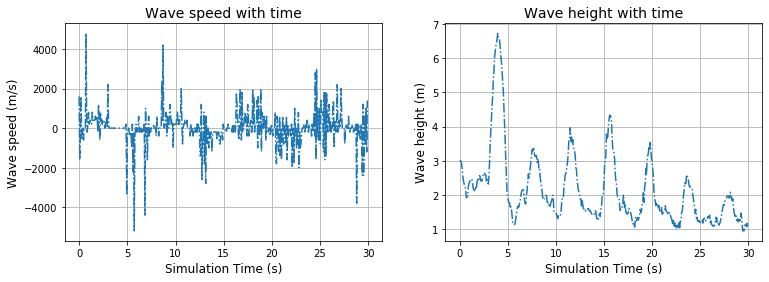

In [9]:
# extra graph for analysis of data 
# compute wave speed from changing crest x-position
Wave_speeds = []
for itr in range(len(data)-1):
    Wave_speeds.append((crest_xs[itr+1]-crest_xs[itr])/time_step/import_freq*1000)

# plot wave height and speed
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12.5,4))

ax1.plot(time_in_s[:-1], Wave_speeds,'-.')
ax1.set_title('Wave speed with time', fontsize = 14)
ax1.grid()
ax1.set_xlabel('Simulation Time (s)', fontsize = 12)
ax1.set_ylabel('Wave speed (m/s)', fontsize = 12)

ax2.plot(time_in_s, Wave_heights,'-.')
ax2.set_title('Wave height with time', fontsize = 14)
ax2.grid()
ax2.set_xlabel('Simulation Time (s)', fontsize = 12)
ax2.set_ylabel('Wave height (m)', fontsize = 12)


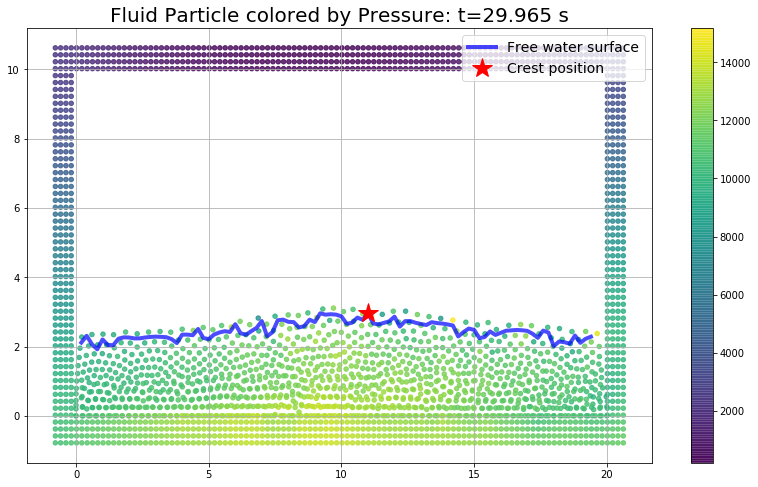

Crest Position ⟶ X: 11.0 | Y: 2.9629445


In [48]:
# -------- Generate graph with crest info for desired iteration --------

itr = 461

fig = plt.figure(figsize=(14,8))
ax_p=plt.scatter(data[itr].x, data[itr].y, s=20, c=data[itr].pressure, alpha=0.8)  #plot data 
plt.plot(x[1:-2], water_heights[itr][1:-2],'-b' , linewidth=4.0, alpha=0.7,label='Free water surface')  #smoothed water surface
plt.plot(crest_xs[itr], crest_ys[itr], '*r', markersize=20, label='Crest position')
plt.legend(loc='upper right', fontsize = 14)
plt.grid()
plt.colorbar(ax_p)
plt.title('Fluid Particle colored by Pressure: t=%s s' %(50*0.0013*itr), fontsize = 20)
plt.show()

print("Crest Position ⟶ X: %s | Y: %s"%(crest_xs[itr], crest_ys[itr]))



In [57]:
# -------- Python Post Pro gif maker --------

def create_animation():
    
    fig = plt.figure(figsize=(14,8))
    plt.grid()
    plt.title('Fluid Particle colored by Pressure', fontsize = 20)
    plt.colorbar(ax_p)    
    ims = []
        
    for i in range(total_file):
        ax_1=plt.scatter(data[i].x, data[i].y, s=20, c=data[i].pressure, alpha=0.8)  #plot data 
        ax_2,=plt.plot(x[1:-2], water_heights[i][1:-2],'-b' , linewidth=4.0, alpha=0.7,label='Free water surface')  #smoothed water surface
        ax_3,=plt.plot(crest_xs[i], crest_ys[i], '*r', markersize=20, label='Crest position')
        ims.append([ax_1]+[ax_2]+[ax_3])

    print('Finished plots for frames, building animation...')
    
    ani = animation.ArtistAnimation(fig, ims, interval=50*1.3, blit=True)
    print('--- ignore the warning ---')
    print('processing...')
    plt.close(fig)
    plt.show()
    
    ani.save('animation.gif', fps=15, extra_args=['-vcodec', 'libx264'])
    
    print('--- Animation created ---')


    return ani

In [58]:
anim = create_animation()

Finished plots for frames, building animation...


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


--- ignore the warning ---
processing...
--- Animation created ---
